<a href="https://colab.research.google.com/github/PhungHaThiKim/An-English-Vietnamese-machine-translation-model-using-Transformer-combined-with-Back-translation/blob/main/EN_VI_Token_USING_Token_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main Train

In [ ]:

!pip3 install fairseq
!pip3 install fastBPE
!pip3 install transformers
!pip3 install sentencepiece

!pip install datasets

!pip install tensorflow-addons

     |████████████████████████████████| 1.7 MB 9.9 MB/s 
     |████████████████████████████████| 145 kB 96.2 MB/s 
     |████████████████████████████████| 90 kB 14.1 MB/s 
     |████████████████████████████████| 74 kB 4.6 MB/s 
     |████████████████████████████████| 112 kB 77.7 MB/s 
     |████████████████████████████████| 596 kB 72.6 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=eceee83600e1bdd5fc9c3a8b6b711dc57b6039b16b3da51448dd4325d900b9f7
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
Successfully built antlr4-python3-runtime
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp37-cp37m-linux_x86_64.whl size=483112 sha256=b0b346907801e6bc7b40c24a6919062e71ccf53551d106a2d175968a026cec76
  Stored in directory: /root/.cache/pip/wheels/bd/d4/0e/0d317a65f77d3f8049fedd8a2ee0519164cf3e6bd77ef886f1
Successfully built fastBPE
     |████████████████████████████████| 3.4 MB 8.4 MB/s 
     |████████████████████████████████| 895 kB 76.1 MB/s 
     |████████████████████████████████| 3.3 MB 58.5 MB/s 
     |████████████████████████████████| 67 kB 7.5 MB/s 
     |████████████████████████████████| 1.2 MB 7.8 MB/s 
     |████████████████████████████████| 306 kB 9.7 MB/s 
     |████████████████████████████████| 133 kB 89.8 MB/s 
     |████████████████████████████████| 243 kB 68.9 MB/s 
     |████████████████████████████████| 1.1 MB 72.6 MB/s 
     |████████████████████████████████| 160 kB 82.0 MB/s 
     |████████████████████████████████| 271 kB 84.9 MB/s 
     |████████████████████████████████| 192 kB 108.1 MB/s 
     |████

In [ ]:
FROM = "EN"
TO = "VI"

BASE_URL = "/content/drive/MyDrive/Colab Notebooks _1/NMT/"
VLSP_URL = "/content/drive/MyDrive/Colab Notebooks _1/MT-EV-VLSP2020/"

MAX_SENTANCE = 50
BATCH_SIZE = 128

EMBEDED_DIM = 256
LATENT_DIM = 2048
NUM_HEADS = 8

print("FROM: {} -> TO: {}".format(FROM, TO))
print("")
print('BASE_URL:', BASE_URL)
print('MAX_SENTANCE:', MAX_SENTANCE)
print('BATCH_SIZE:', BATCH_SIZE)
print("")
print('EMBEDED_DIM:', EMBEDED_DIM)
print('LATENT_DIM:', LATENT_DIM)
print('NUM_HEADS:', NUM_HEADS)

if FROM == "EN":
  ID_TRAIN = "en"
  ID_LABEL = "word_segment_vi"
  CMASK = 0
else:
  ID_TRAIN = "word_segment_vi"
  ID_LABEL = "en"
  CMASK = 1

print("")
print("ID_TRAIN:", ID_TRAIN)
print("ID_LABEL:", ID_LABEL)
print("CMASK:", CMASK)

FROM: EN -> TO: VI

BASE_URL: /content/drive/MyDrive/Colab Notebooks _1/NMT/
MAX_SENTANCE: 50
BATCH_SIZE: 128

EMBEDED_DIM: 256
LATENT_DIM: 2048
NUM_HEADS: 8

ID_TRAIN: en
ID_LABEL: word_segment_vi
CMASK: 0


In [ ]:
import torch
import random
from transformers import AutoModel, AutoTokenizer, AlbertTokenizer, TFAlbertModel, BertTokenizer
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils
from datasets import load_dataset
from tensorflow_addons.layers import CRF


In [ ]:
tokenizer_vi = AutoTokenizer.from_pretrained("vinai/phobert-large", use_fast=False)
tokenizer_en = BertTokenizer.from_pretrained('bert-large-uncased', use_fast=False)

if FROM == "EN":
  tokenizer_train = tokenizer_en
  tokenizer_label = tokenizer_vi
else:
  tokenizer_train = tokenizer_vi
  tokenizer_label = tokenizer_en

VOCAB_SIZE_TRAIN = tokenizer_train.vocab_size
VOCAB_SIZE_LABEL = tokenizer_label.vocab_size

print('VOCAB_SIZE_TRAIN:', VOCAB_SIZE_TRAIN)
print('VOCAB_SIZE_LABEL:', VOCAB_SIZE_LABEL)

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

VOCAB_SIZE_TRAIN: 30522
VOCAB_SIZE_LABEL: 64000


In [ ]:
dataset = load_dataset('csv', data_files={
    'train': [
              BASE_URL + 'train.csv',
              VLSP_URL + "basic/"+"train.csv",
              VLSP_URL + "evbcorpus/"+"train.csv",
              VLSP_URL + "indomain-news/"+"train.csv",
              VLSP_URL + "openSub/"+"train.csv",
              VLSP_URL + "ted-like/"+"train.csv",
              VLSP_URL + "wiki-alt/"+"train.csv"
    ], 
    'test': [
              BASE_URL + 'test.csv',
              VLSP_URL + "basic/"+"test.csv",
              VLSP_URL + "evbcorpus/"+"test.csv",
              VLSP_URL + "indomain-news/"+"test.csv",
              VLSP_URL + "openSub/"+"test.csv",
              VLSP_URL + "ted-like/"+"test.csv",
              VLSP_URL + "wiki-alt/"+"test.csv"
    ], 
    'validation': [
              BASE_URL + 'validation.csv',
              VLSP_URL + "basic/"+"validation.csv",
              VLSP_URL + "evbcorpus/"+"validation.csv",
              VLSP_URL + "indomain-news/"+"validation.csv",
              VLSP_URL + "openSub/"+"validation.csv",
              VLSP_URL + "ted-like/"+"validation.csv",
              VLSP_URL + "wiki-alt/"+"validation.csv"
    ]})

dataset = dataset.shuffle(seed=50)

print(dataset)
print(dataset['train'][0])

Using custom data configuration default-506d2e25704a4c0c


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-506d2e25704a4c0c/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['en', 'vi', 'word_segment_vi'],
        num_rows: 3805216
    })
    test: Dataset({
        features: ['en', 'vi', 'word_segment_vi'],
        num_rows: 205275
    })
    validation: Dataset({
        features: ['en', 'vi', 'word_segment_vi'],
        num_rows: 205557
    })
})
{'en': 'where the hell is the asset?', 'vi': 'tài sản đang ở chỗ quái nào vậy?', 'word_segment_vi': 'tài_sản đang ở chỗ quái nào vậy ?'}


In [ ]:
print("")
print('john, did you see news today ?')
print("")
ten = tokenizer_en('john, did you see news today ?', max_length=MAX_SENTANCE, padding='max_length', truncation=True)
print(ten['input_ids'])
print("")
print(ten['attention_mask'])
print("")

print(tokenizer_en.convert_ids_to_tokens(ten['input_ids']))


john, did you see news today ?

[101, 2198, 1010, 2106, 2017, 2156, 2739, 2651, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

['[CLS]', 'john', ',', 'did', 'you', 'see', 'news', 'today', '?', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
print("")
print('john')
print("")
ten = tokenizer_vi('jo hn', max_length=MAX_SENTANCE, padding='max_length', truncation=True)
print(ten['input_ids'])
print("")
print(ten['attention_mask'])
print("")
print(tokenizer_vi.convert_ids_to_tokens(ten['input_ids']))


john

[0, 16414, 26401, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

['<s>', 'jo', 'hn', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [ ]:
ens = []
vis = []

for dt in dataset['train']:
  ens.append(len(dt['en'].split(' ')))
  vis.append(len(dt['word_segment_vi'].split(' ')))

print(len(ens))
print(len(vis))

133149
133149


5


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f420e17dc10>]],
      dtype=object)

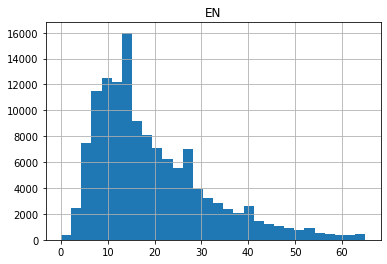

In [ ]:
import numpy as np
import pandas as pd
print(ens[0])
gym = pd.DataFrame({'EN': ens})
gym.hist(bins=30, range=[0, 65])

In [ ]:
def token_encoder(data):
  token_res = tokenizer_train(data, max_length=MAX_SENTANCE, padding='max_length', truncation=True)
  # print(token_res)
  return {'encoder': token_res['input_ids'], 'emask': token_res['attention_mask']}

def token_decoder(data):
  token_res = tokenizer_label(data, max_length=MAX_SENTANCE+1, padding='max_length', truncation=True)
  return {'decoder': token_res['input_ids'], 'dmask': token_res['attention_mask']}

def format_dataset(train, label, train_mask, label_mask):
  return ({"encoder_inputs": train, "encoder_masks": train_mask, "decoder_inputs": label[:, :-1], "decoder_masks": label_mask[:, :-1]}, label[:, 1:])

def make_dataset(data_type):
  dataset_train = dataset.get(data_type)
  dataset_train = dataset_train.map(lambda e: token_encoder(e[ID_TRAIN]), batched=True)
  dataset_train = dataset_train.map(lambda e: token_decoder(e[ID_LABEL]), batched=True)

  tf_dataset_train = tf.data.Dataset.from_tensor_slices((dataset_train['encoder'], dataset_train['decoder'], dataset_train['emask'], dataset_train['dmask']))
  tf_dataset_train = tf_dataset_train.batch(BATCH_SIZE)
  tf_dataset_train = tf_dataset_train.map(format_dataset)
  return tf_dataset_train.prefetch(16).cache()

train_ds = make_dataset('train')
val_ds = make_dataset('validation')

  0%|          | 0/3806 [00:00<?, ?ba/s]

  0%|          | 0/3806 [00:00<?, ?ba/s]

  0%|          | 0/206 [00:00<?, ?ba/s]

  0%|          | 0/206 [00:00<?, ?ba/s]

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")
    print(inputs["encoder_inputs"])
    print(inputs["decoder_inputs"])

inputs["encoder_inputs"].shape: (128, 50)
inputs["decoder_inputs"].shape: (128, 50)
targets.shape: (128, 50)
tf.Tensor(
[[  101  2073  1996 ...     0     0     0]
 [  101  2008  1005 ...     0     0     0]
 [  101  2097  2017 ...     0     0     0]
 ...
 [  101  2467  3342 ...     0     0     0]
 [  101 20907  2027 ...     0     0     0]
 [  101  2057  8439 ...     0     0     0]], shape=(128, 50), dtype=int32)
tf.Tensor(
[[    0   540    52 ...     1     1     1]
 [    0    83     8 ...     1     1     1]
 [    0    83    38 ...     1     1     1]
 ...
 [    0   852   236 ...     1     1     1]
 [    0 13061 39187 ...     1     1     1]
 [    0   507    41 ...     1     1     1]], shape=(128, 50), dtype=int32)


In [ ]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, CMASK)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


In [ ]:

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
encoder_masks = keras.Input(shape=(None,), dtype="int64", name="encoder_masks")
x = PositionalEmbedding(MAX_SENTANCE, VOCAB_SIZE_TRAIN, EMBEDED_DIM)(encoder_inputs)
encoder_outputs = TransformerEncoder(EMBEDED_DIM, LATENT_DIM, NUM_HEADS)(x, mask=encoder_masks)
encoder = keras.Model([encoder_inputs, encoder_masks], encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
decoder_masks = keras.Input(shape=(None,), dtype="int64", name="decoder_masks")
encoded_seq_inputs = keras.Input(shape=(None, EMBEDED_DIM), name="decoder_state_inputs")
x = PositionalEmbedding(MAX_SENTANCE, VOCAB_SIZE_LABEL, EMBEDED_DIM)(decoder_inputs)
x = TransformerDecoder(EMBEDED_DIM, LATENT_DIM, NUM_HEADS)(x, encoded_seq_inputs, mask=decoder_masks)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(VOCAB_SIZE_LABEL, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs, decoder_masks], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs, decoder_masks])

if 'transformer' in globals():
  del transformer
  print("DEL transformer")
  
transformer = keras.Model(
    [encoder_inputs, decoder_inputs, encoder_masks, decoder_masks], decoder_outputs, name="transformer"
)

In [ ]:
import datetime;
ts = int(datetime.datetime.now().timestamp())

epochs = 10  # This should be at least 30 for convergence

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=BASE_URL + "{}-{}-BLEU_{:.4f}-MAX_SENTANCE_{}-HEADS_{}-TIME_{}".format(FROM, TO, 0, MAX_SENTANCE, NUM_HEADS, ts),
    monitor='val_loss',
    mode='min',
    save_best_only=True, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(BASE_URL + "{}-{}-BLEU_{:.4f}-MAX_SENTANCE_{}-HEADS_{}-TIME_{}_history.csv".format(FROM, TO, 0, MAX_SENTANCE, NUM_HEADS, ts), append=True)

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"],
)
transformer.fit(
    train_ds, 
    epochs=epochs, 
    validation_data=val_ds, 
    callbacks=[callback, model_checkpoint_callback, csv_logger]
)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   7826432     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 encoder_masks (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                     

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_50-HEADS_8-TIME_1641919736/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_50-HEADS_8-TIME_1641919736/assets


29729/29729 [==============================] - 10504s 353ms/step - loss: 0.8234 - accuracy: 0.4496 - val_loss: 0.7090 - val_accuracy: 0.4997


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/10
29729/29729 [==============================] - ETA: 0s - loss: 0.7441 - accuracy: 0.4978
Epoch 00002: val_loss improved from 0.70897 to 0.67655, saving model to /content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_50-HEADS_8-TIME_1641919736


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_50-HEADS_8-TIME_1641919736/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_50-HEADS_8-TIME_1641919736/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


29729/29729 [==============================] - 10409s 350ms/step - loss: 0.7441 - accuracy: 0.4978 - val_loss: 0.6766 - val_accuracy: 0.5188
Epoch 3/10
29729/29729 [==============================] - ETA: 0s - loss: 0.7215 - accuracy: 0.5105
Epoch 00003: val_loss improved from 0.67655 to 0.66115, saving model to /content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_50-HEADS_8-TIME_1641919736


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_50-HEADS_8-TIME_1641919736/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_50-HEADS_8-TIME_1641919736/assets


29729/29729 [==============================] - 10405s 350ms/step - loss: 0.7215 - accuracy: 0.5105 - val_loss: 0.6612 - val_accuracy: 0.5269


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 4/10
29729/29729 [==============================] - ETA: 0s - loss: 0.7088 - accuracy: 0.5175
Epoch 00004: val_loss improved from 0.66115 to 0.65412, saving model to /content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_50-HEADS_8-TIME_1641919736


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_50-HEADS_8-TIME_1641919736/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_50-HEADS_8-TIME_1641919736/assets


29729/29729 [==============================] - 10407s 350ms/step - loss: 0.7088 - accuracy: 0.5175 - val_loss: 0.6541 - val_accuracy: 0.5319


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 5/10
   70/29729 [..............................] - ETA: 2:47:00 - loss: 0.6918 - accuracy: 0.5226

KeyboardInterrupt: ignored

In [ ]:
list_special = [s for s in list(tokenizer_label. .values())]
print(list_special)
def decode_sentance_fun(sentance):
  tk = tokenizer_train(sentance, max_length=MAX_SENTANCE, padding='max_length', truncation=True)
  tokenized_input_sentence = np.array(tk['input_ids'])
  mask_input = np.array(tk['attention_mask'])
  decoded_sentence = np.empty((len(sentance)), dtype=str)
  has_end = False
  for i in range(MAX_SENTANCE):
    tk_o = tokenizer_label(list(decoded_sentence), max_length=MAX_SENTANCE+1, padding='max_length', truncation=True)
    tokenized_target_sentence = np.array(tk_o['input_ids'])[:, :-1]
    mask_out = np.array(tk_o['attention_mask'])[:, :-1]
    predictions = transformer([tokenized_input_sentence, tokenized_target_sentence, mask_input, mask_out])
    sampled_token_index = np.argmax(predictions[:, i, :], axis=1)
    token = tokenizer_label.convert_ids_to_tokens(sampled_token_index)
    
    space = np.array([" "]*len(sentance))
    # print(token)
    decoded_sentence = np.core.defchararray.add(decoded_sentence, space)
    decoded_sentence =  np.core.defchararray.add(decoded_sentence, np.array(token))
    decoded_sentence = np.char.strip(decoded_sentence)
  rs = []
  for decode in decoded_sentence:
    for sp in list_special:
      decode = decode.replace(sp, "")
    decode = decode.strip()
    rs.append(decode)
  return rs


text = ["tôi tên là.", "I hope that these images awaken a force in those who view them , people like you."]
decode_sentance_fun(text)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']


['my name is .   ##s . . .  .   .  ##s  . . . .   .   .      ##s . . . . . . . .',
 'the way that these are a little . . . . that these these are the people who look at them , people like young .   ##s ##s ##s . . . . . . .  .       .']

In [ ]:
list_special = [s for s in list(tokenizer_label.special_tokens_map_extended.values())]
print(list_special)
def beam_search(sentance, k=3):
  tk = tokenizer_train(sentance, max_length=MAX_SENTANCE, padding='max_length', truncation=True)
  tokenized_input_sentance = np.array([tk['input_ids']])
  mask_input = np.array([tk['attention_mask']])

  clone = np.array(tokenized_input_sentance)
  maskc = np.array(mask_input)
  for j in range(k-1):
    clone = np.append(clone, tokenized_input_sentance, axis=0)
    maskc = np.append(maskc, mask_input, axis=0)

  print(tokenized_input_sentance)
  print(mask_input)

  decoded_sentence = np.empty(1, dtype=str)
  decoded_p = np.empty(1, dtype=float)
  print(decoded_sentence)
  print(decoded_p)

  tk_o = tokenizer_label(list(decoded_sentence), max_length=MAX_SENTANCE+1, padding='max_length', truncation=True)
  tokenized_target_sentence = np.array(tk_o['input_ids'])[:, :-1]
  mask_out = np.array(tk_o['attention_mask'])[:, :-1]
  print(tokenized_target_sentence)
  
  predictions = transformer([tokenized_input_sentance, tokenized_target_sentence, mask_input, mask_out])
  p_n = (predictions[:, 0, :])
  p_k = np.argpartition(p_n, -k, axis=1)[:, -k:]
  print(p_k[0])
  token = tokenizer_label.convert_ids_to_tokens(p_k[0])
  p_p = np.log(np.take(p_n, p_k))[0]
  
  space = np.array([" "]*k)
  decoded_sentence = np.core.defchararray.add([""]*k, space)
  decoded_sentence =  np.core.defchararray.add(decoded_sentence, np.array(token))
  decoded_sentence = np.char.strip(decoded_sentence)
  print(decoded_sentence)
  print(p_p)
  for i in range(1, MAX_SENTANCE):
    tk_o = tokenizer_label(list(decoded_sentence), max_length=MAX_SENTANCE+1, padding='max_length', truncation=True)
    tokenized_target_sentence = np.array(tk_o['input_ids'])[:, :-1]
    mask_out = np.array(tk_o['attention_mask'])[:, :-1]
    print(tokenized_target_sentence)
    
    predictions = transformer([clone, tokenized_target_sentence, maskc, mask_out])
    # print(predictions)

    pt = []
    vt = []
    for j, ds in enumerate(decoded_sentence):
      pp_n = predictions[j, i, :]
      print(p_n)
      pp_k = np.argpartition(pp_n, -k, axis=0)[-k:]
      print(pp_k)
      token = tokenizer_label.convert_ids_to_tokens(pp_k)
      print(token)
      pp_p = np.log(np.take(pp_n, pp_k))
      print(pp_p)
      dcs = np.core.defchararray.add([ds]*k, space)
      dcs =  np.core.defchararray.add(dcs, np.array(token))
      dcs = np.char.strip(dcs)
      print(dcs)

      for l in range(k):
        pt.append(dcs[l])
        vt.append(pp_p[l]+p_p[j])

    print(pt)
    print(vt)

    hope = np.argpartition(vt, -k, axis=0)[-k:]
    print(hope)
    decoded_sentence = np.take(pt, hope)
    p_p = np.take(vt, hope)

  print(decoded_sentence)
  print(p_p)
  no1 = np.argpartition(p_p, -1, axis=0)[-1:]
  print(no1)
  print(p_p[no1])
  rs = []
  for decode in decoded_sentence[no1]:
    for sp in list_special:
      decode = decode.replace(sp, "")
    decode = decode.strip()
    rs.append(decode)
  return rs


  


text = "I hope that these images awaken a force in those who view them , people like you."
print(beam_search(text))

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
[[    0  1555  3040  8184 26116  1981 11487  3536 24612  5961  3796  2052
   1517 50628   858  5642  4219  2303  4050  9328 52714     4  6122 49928
   6955 33793     5     2     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1]]
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
['']
[0.]
[[101 102   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
[1998 1996 2002]
['and' 'the' 'he']
[-3.2437503 -3.21901   -2.8417823]
[[ 101 1998  102    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

chencherry = SmoothingFunction()

def predict_output(sentance_train):
  return {"predict": decode_sentance_fun(sentance_train)}

data_test = dataset.get('test')

data_test = data_test.map(lambda e: predict_output(e[ID_TRAIN]), batched=True, batch_size=128)
print(data_test)

output_label = [text.split() for text in data_test[ID_LABEL]]
output_predict = [text.split() for text in data_test['predict']]

print(output_label[12])
print(output_predict[12])
print(data_test[12])
bleu1 = 0.0
count = 0
for i in range(len(output_label)):
  label = output_label[i][:MAX_SENTANCE]
  predict = output_predict[i]
  b = sentence_bleu([label], predict, smoothing_function=chencherry.method0)
  bleu1 += b
  count += 1

  print("BLUE: {} || {} || {}".format(b, " ".join(label), " ".join(predict)))
bleu = bleu1/count

print("BLEU-1: {:.4f}".format(bleu))

INFO:tensorflow:Assets written to: ram://f862d7d6-16ec-4031-868f-19546b65469b/assets


INFO:tensorflow:Assets written to: ram://f862d7d6-16ec-4031-868f-19546b65469b/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


  0%|          | 0/1604 [00:00<?, ?ba/s]

Dataset({
    features: ['en', 'predict', 'vi', 'word_segment_vi'],
    num_rows: 205275
})
['on', 'planning', 'your', 'meals', 'and', 'shopping', 'to', 'match', 'your', 'plans.']
['in', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'of', 'the', 'the', 'the', 'the', '.', '.', '.', 'of', 'the', 'the', '.', '.', '.', 'the', '##s', '##s', '.', '.', '.', '.', '.', '.']
{'en': 'on planning your meals and shopping to match your plans.', 'predict': 'in the the the the the the the the the the the the the the the of the the the the . . . of the the . . . the   ##s ##s . . . . . .', 'vi': 'trong tính toán chợ búa mua sắm cho phù hợp với lịch sinh hoạt.', 'word_segment_vi': 'trong tính_toán chợ_búa mua_sắm cho phù_hợp với lịch sinh_hoạt .'}
BLUE: 0.5 || there's a metaphor which i love || a , i ' ve got a ' s a ' . . . a . ##s . . . . ##s . . . . . . . ##s . ##s
BLUE: 0 || hello... hello. hello, haha! || hello . . . ha . . . . ##s . . . . 

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Streaming output truncated to the last 5000 lines.
BLUE: 0.14983545225795816 || of course i do. you know i do. || of course you know i do . ##s ##s ##s . . . . . . . . ##s ##s . . . . . . . . . . . .
BLUE: 0.5216948600244291 || i did read it, detective. || i ' ve been read so much . ##s ##s . . . . . . . ##s . . . . . . . . .
BLUE: 0.1382109806372432 || well, now we have a bigger problem. || well , we have a very much more serious problem now . ##s ##s . . . . . . . . . . . . . . .
BLUE: 0.5828233954152654 || because you left us! || because i left you . ##s ##s . . . . . . ##s ##s . . . . . . . . . . .
BLUE: 0.1250305362182298 || have you got a pate, grandpa? || do you have a . . . you got a little bit of a . . . ##s ##s ? . ? . . . . . . . . . . .
BLUE: 0.5039843787265444 || no, really, where are you going? || no , really . where do you go ? ##s . . . . . ##s . . . . . . . ##s . . . . . . .
BLUE: 0.30394778395171435 || his father was an elder of the sons of mithras, devoted to the boo

# Save model

In [ ]:
import datetime;
ts = int(datetime.datetime.now().timestamp())

transformer.save(BASE_URL + "{}-{}-BLEU_{:.4f}-MAX_SENTANCE_{}-HEADS_{}-TIME_{}".format(FROM, TO, bleu, MAX_SENTANCE, NUM_HEADS, ts))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.4243-MAX_SENTANCE_30-HEADS_8-TIME_1640975262/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.4243-MAX_SENTANCE_30-HEADS_8-TIME_1640975262/assets


# Loss - Accurency

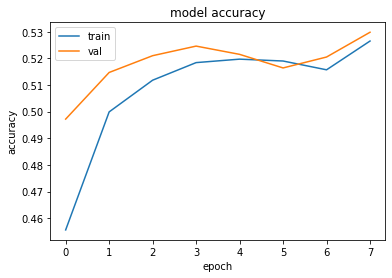

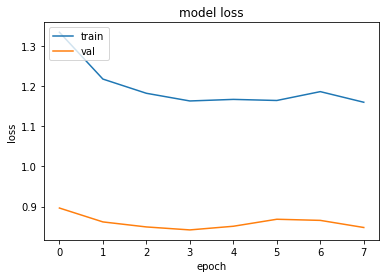

In [ ]:
import keras
from matplotlib import pyplot as plt
import pandas as pd

history = [
  {"epoch": 0, "loss": 1.3334 , "accurancy": 0.4556, "val_loss": 0.8965, "val_accurancy": 0.4972},
  {"epoch": 1, "loss": 1.2170 , "accurancy": 0.4999, "val_loss": 0.8620, "val_accurancy": 0.5147},
  {"epoch": 2, "loss": 1.1817 , "accurancy": 0.5118, "val_loss": 0.8495, "val_accurancy": 0.5210},
  {"epoch": 3, "loss": 1.1626 , "accurancy": 0.5184, "val_loss": 0.8421, "val_accurancy": 0.5246},
  {"epoch": 4, "loss": 1.1665 , "accurancy": 0.5197, "val_loss": 0.8512, "val_accurancy": 0.5215},
  {"epoch": 5, "loss": 1.1638 , "accurancy": 0.5190, "val_loss": 0.8686, "val_accurancy": 0.5164},
  {"epoch": 6, "loss": 1.1858 , "accurancy": 0.5157, "val_loss": 0.8658, "val_accurancy": 0.5205},
  {"epoch": 7, "loss": 1.1594 , "accurancy": 0.5265, "val_loss": 0.8481, "val_accurancy": 0.5298}
]

df = pd.DataFrame(history)

df['accurancy']

plt.plot(df['accurancy'])
plt.plot(df['val_accurancy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(df['loss'])
plt.plot(df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Load model


In [ ]:
print(tf.__version__)

PATH_MODEL = '/content/drive/MyDrive/Colab Notebooks _1/NMT/VI-EN-BLEU_0.0000-MAX_SENTANCE_50-HEADS_8-TIME_1641269885'

transformer = tf.saved_model.load(PATH_MODEL)

2.7.0


ValueError: ignored

#Continute Train


In [ ]:

new_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_40-HEADS_8-TIME_1640521707')

import datetime;
ts = int(datetime.datetime.now().timestamp())

epochs = 10  # This should be at least 30 for convergence

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=BASE_URL + "{}-{}-BLEU_{:.4f}-MAX_SENTANCE_{}-HEADS_{}-TIME_{}".format(FROM, TO, 0, MAX_SENTANCE, NUM_HEADS, ts),
    monitor='val_loss',
    mode='min',
    save_best_only=True, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger(BASE_URL + "{}-{}-BLEU_{:.4f}-MAX_SENTANCE_{}-HEADS_{}-TIME_{}_history.csv".format(FROM, TO, 0, MAX_SENTANCE, NUM_HEADS, ts), append=True)

# new_model.summary()
# new_model.compile(
#     "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"],
# )
new_model.fit(
    train_ds, 
    epochs=epochs, 
    validation_data=val_ds, 
    callbacks=[callback, model_checkpoint_callback, csv_logger]
)

Epoch 1/10
29729/29729 [==============================] - ETA: 0s - loss: 0.8562 - accuracy: 0.8716
Epoch 00001: val_loss improved from inf to 0.80026, saving model to /content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_50-HEADS_8-TIME_1641895081


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_50-HEADS_8-TIME_1641895081/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_50-HEADS_8-TIME_1641895081/assets


29729/29729 [==============================] - 9323s 313ms/step - loss: 0.8562 - accuracy: 0.8716 - val_loss: 0.8003 - val_accuracy: 0.8781
Epoch 2/10
24225/29729 [=======================>......] - ETA: 27:47 - loss: 0.8523 - accuracy: 0.8722

# Pre Data

In [ ]:
!pip3 install vncorenlp
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://github.com/vncorenlp/VnCoreNLP/raw/master/VnCoreNLP-1.1.1.jar
!wget https://github.com/vncorenlp/VnCoreNLP/raw/master/models/wordsegmenter/vi-vocab
!wget https://github.com/vncorenlp/VnCoreNLP/raw/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

     |████████████████████████████████| 2.6 MB 4.2 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=61a62822a8c297bd0499e5217a4334c0a9f3cdebaed7320aa6045caa94458af4
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp
--2021-12-23 06:28:44--  https://github.com/vncorenlp/VnCoreNLP/raw/master/VnCoreNLP-1.1.1.jar
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar [following]
--2021-12-23 06:28:44--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

In [ ]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("/content/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

text = "Ông Nguyễn Khắc Chúc  đang làm việc tại Đại học Quốc gia Hà Nội. Bà Lan, vợ ông Chúc, cũng làm việc tại đây."

word_segmented_text = rdrsegmenter.tokenize(text) 
print(word_segmented_text)

[['Ông', 'Nguyễn_Khắc_Chúc', 'đang', 'làm_việc', 'tại', 'Đại_học', 'Quốc_gia', 'Hà_Nội', '.'], ['Bà', 'Lan', ',', 'vợ', 'ông', 'Chúc', ',', 'cũng', 'làm_việc', 'tại', 'đây', '.']]


In [ ]:
import pandas as pd
import html
import re

def word_segment_vi(vi):
  txt = []
  segments = rdrsegmenter.tokenize(vi)
  for seg in segments:
    txt.append(" ".join(seg))
  seg_vi = " ".join(txt)
  return seg_vi

def remove_special(text):
  output = ""
  for character in text:
      # if character.isalnum() and "\"".find(character) == -1:
      if character.isalnum() or ".,!?' ".find(character) != -1:
          output += character
  # print(output)
  return output

base_url = "/content/drive/MyDrive/Colab Notebooks _1/NMT/"
data_train_en = []
data_train_vi = []
data_train_word_segment = []
datas_en = []
datas_vi = []
fp = open('tst2012.en')
for i, line in enumerate(fp):
  datas_en.append(line)
  
fp.close()
fp = open('tst2012.vi')
for i, line in enumerate(fp):
  datas_vi.append(line)
 
fp.close()

for eng, vi in list(zip(datas_en, datas_vi)):
  en_prosess = remove_special(html.unescape(eng.strip())).lower()
  vi_process = remove_special(html.unescape(vi.strip())).lower()

  if en_prosess.strip() != "" and vi_process.strip() != "" and len(en_prosess) > 3 and len(vi_process) > 3:
    data_train_en.append(en_prosess.strip())
    data_train_vi.append(vi_process.strip())
    data_train_word_segment.append(word_segment_vi(vi_process.strip()))

data_train = pd.DataFrame({
    'en': data_train_en,
    'vi': data_train_vi,
    'word_segment_vi': data_train_word_segment
})
data_train.to_csv(base_url+'validation.csv', index=False)

In [ ]:
import pandas as pd
import html
import re

def word_segment_vi(vi):
  txt = []
  segments = rdrsegmenter.tokenize(vi)
  for seg in segments:
    txt.append(" ".join(seg))
  seg_vi = " ".join(txt)
  return seg_vi

def remove_special(text):
  output = ""
  for character in text:
      # if character.isalnum() and "\"".find(character) == -1:
      if character.isalnum() or ".,!?' ".find(character) != -1:
          output += character
  # print(output)
  return output

base_url = "/content/drive/MyDrive/Colab Notebooks _1/MT-EV-VLSP2020"
parent_folder = 'wiki-alt'
en_file = "data.en"
vi_file = "data.vi"

data_train_en = []
data_train_vi = []
data_train_word_segment = []
datas_en = []
datas_vi = []
fp = open("{}/{}/{}".format(base_url, parent_folder, en_file))
for i, line in enumerate(fp):
  datas_en.append(line)
  
fp.close()
fp = open("{}/{}/{}".format(base_url, parent_folder, vi_file))
for i, line in enumerate(fp):
  datas_vi.append(line)
 
fp.close()

for eng, vi in list(zip(datas_en, datas_vi)):
  en_prosess = remove_special(html.unescape(eng.strip())).lower()
  vi_process = remove_special(html.unescape(vi.strip())).lower()

  if en_prosess.strip() != "" and vi_process.strip() != "" and len(en_prosess) > 3 and len(vi_process) > 3:
    data_train_en.append(en_prosess.strip())
    data_train_vi.append(vi_process.strip())
    data_train_word_segment.append(word_segment_vi(vi_process.strip()))

data_train = pd.DataFrame({
    'en': data_train_en,
    'vi': data_train_vi,
    'word_segment_vi': data_train_word_segment
})

train, validate, test = np.split(data_train.sample(frac=1, random_state=42), [int(.9*len(data_train)), int(.95*len(data_train))])

train.to_csv(base_url+'/'+parent_folder+'/train.csv', index=False)
validate.to_csv(base_url+'/'+parent_folder+'/validation.csv', index=False)
test.to_csv(base_url+'/'+parent_folder+'/test.csv', index=False)

# Test Model

In [ ]:
PATH_MODEL = '/content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.3913-MAX_SENTANCE_20-HEADS_8-TIME_1636311047'

dataset_files = [
  '/content/drive/MyDrive/Colab Notebooks _1/MT-EV-VLSP2020/basic.csv'
]

loaded_model = tf.keras.models.load_model(PATH_MODEL)

dataset = load_dataset('csv', data_files=dataset_files)
print(dataset)

Using custom data configuration default-3e7422ca3ea753fe


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-3e7422ca3ea753fe/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['en', 'vi', 'word_segment_vi'],
        num_rows: 8813
    })
})


# Web demo

In [ ]:
!pip install flask-ngrok
!pip install flask-bootstrap

!pip3 install fairseq
!pip3 install fastBPE
!pip3 install transformers
!pip3 install sentencepiece

!pip install datasets

!pip install tensorflow-addons

     |████████████████████████████████| 456 kB 4.2 MB/s 
  Created wheel for flask-bootstrap: filename=Flask_Bootstrap-3.3.7.1-py3-none-any.whl size=460123 sha256=22b6a1f70a4c75633011a8bb4639df353b82c7dc3fd0bbc5a03edbc0b5aa1932
  Stored in directory: /root/.cache/pip/wheels/67/a2/d6/50d039c9b59b4caca6d7b53839c8100354a52ab7553d2456eb
  Created wheel for visitor: filename=visitor-0.1.3-py3-none-any.whl size=3946 sha256=476f3ec2a9e571da22f00e63857101e6873cd3b5079d5c2e638f234e16b492a4
  Stored in directory: /root/.cache/pip/wheels/64/34/11/053f47218984c9a31a00f911ed98dda036b867481dcc527a12
Successfully built flask-bootstrap visitor
     |████████████████████████████████| 1.7 MB 4.0 MB/s 
     |████████████████████████████████| 145 kB 98.9 MB/s 
     |████████████████████████████████| 90 kB 13.2 MB/s 
     |████████████████████████████████| 74 kB 4.6 MB/s 
     |████████████████████████████████| 112 kB 109.1 MB/s 
     |████████████████████████████████| 596 kB 77.8 MB/s 
  Created wheel for

  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp37-cp37m-linux_x86_64.whl size=483174 sha256=b5b645eba8aaf0dc3f0b6153e600de0f31a1bb07a3159620981530441e278d55
  Stored in directory: /root/.cache/pip/wheels/bd/d4/0e/0d317a65f77d3f8049fedd8a2ee0519164cf3e6bd77ef886f1
Successfully built fastBPE
     |████████████████████████████████| 3.4 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 70.5 MB/s 
     |████████████████████████████████| 67 kB 7.3 MB/s 
     |████████████████████████████████| 3.3 MB 52.7 MB/s 
     |████████████████████████████████| 1.2 MB 4.1 MB/s 
     |████████████████████████████████| 306 kB 4.2 MB/s 
     |████████████████████████████████| 133 kB 59.0 MB/s 
     |████████████████████████████████| 243 kB 60.5 MB/s 
     |████████████████████████████████| 1.1 MB 91.1 MB/s 
     |████████████████████████████████| 271 kB 82.3 MB/s 
     |████████████████████████████████| 160 kB 94.5 MB/s 
     |████████████████████████████████| 192 kB 91.6 MB/s 
     |█████

In [ ]:
!pip3 install vncorenlp
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://github.com/vncorenlp/VnCoreNLP/raw/master/VnCoreNLP-1.1.1.jar
!wget https://github.com/vncorenlp/VnCoreNLP/raw/master/models/wordsegmenter/vi-vocab
!wget https://github.com/vncorenlp/VnCoreNLP/raw/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

     |████████████████████████████████| 2.6 MB 4.1 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=1710f6446583c1cda2716ab8291b1ab69080da7297d2765df00220479f886bb2
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp
--2022-01-13 14:20:02--  https://github.com/vncorenlp/VnCoreNLP/raw/master/VnCoreNLP-1.1.1.jar
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar [following]
--2022-01-13 14:20:02--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

In [ ]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("/content/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

text = "Ông Nguyễn Khắc Chúc  đang làm việc tại Đại học Quốc gia Hà Nội. Bà Lan, vợ ông Chúc, cũng làm việc tại đây."

word_segmented_text = rdrsegmenter.tokenize(text) 
print(word_segmented_text)

[['Ông', 'Nguyễn_Khắc_Chúc', 'đang', 'làm_việc', 'tại', 'Đại_học', 'Quốc_gia', 'Hà_Nội', '.'], ['Bà', 'Lan', ',', 'vợ', 'ông', 'Chúc', ',', 'cũng', 'làm_việc', 'tại', 'đây', '.']]


In [ ]:
import pandas as pd
import html
import re

def word_segment_vi(vi):
  txt = []
  segments = rdrsegmenter.tokenize(vi)
  for seg in segments:
    txt.append(" ".join(seg))
  seg_vi = " ".join(txt)
  return seg_vi

def remove_special(text):
  output = ""
  for character in text:
      # if character.isalnum() and "\"".find(character) == -1:
      if character.isalnum() or ".,!?' ".find(character) != -1:
          output += character
  # print(output)
  return output

In [ ]:
WEB_TRANSLATE_FROM = 'EN'
WEB_TRANSLATE_TO = 'VI'
MAX_SENTANCE = 50

In [ ]:
import pandas as pd
import html
import re
import torch
import random
from transformers import AutoModel, AutoTokenizer, AlbertTokenizer, TFAlbertModel, BertTokenizer
import numpy as np
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers, utils
from datasets import load_dataset
from tensorflow_addons.layers import CRF
from tensorflow.keras import layers , activations , models , preprocessing , utils

**- Model LSTM**



In [ ]:
def remove_special(text):
  output = ""
  for character in text:
      # if character.isalnum() and "\"".find(character) == -1:
      if character.isalnum() or ".,!?' ".find(character) != -1:
          output += character
  # print(output)
  return output

In [ ]:
import pickle

max_input_length = 48
max_output_length = 53

with open('/content/drive/MyDrive/Colab Notebooks _1/NMT/LSTM_input_token.pkl', 'rb') as f:
    eng_word_dict = pickle.load(f)
    num_eng_tokens = len( eng_word_dict )+1

with open('/content/drive/MyDrive/Colab Notebooks _1/NMT/LSTM_output_token.pkl', 'rb') as f:
    french_word_dict = pickle.load(f)
    num_french_tokens = len( french_word_dict )+1

encoder_inputs = tf.keras.layers.Input(shape=( 48 ,  ))
encoder_embedding = tf.keras.layers.Embedding( num_eng_tokens, 256 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 256 , return_state=True , recurrent_dropout=0.2 , dropout=0.2 )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = tf.keras.layers.Input(shape=( 53 , ))
decoder_embedding = tf.keras.layers.Embedding( num_french_tokens, 256 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 256 , return_state=True , return_sequences=True , recurrent_dropout=0.2 , dropout=0.2)
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( num_french_tokens , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model_lstm = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )

def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 256,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 256 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model
  
enc_model , dec_model = make_inference_models()
model_lstm = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks _1/NMT/LSTM_model.h5')
enc_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks _1/NMT/LSTM_enc_model.h5')
dec_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks _1/NMT/LSTM_dec_model.h5')

def str_to_tokens( sentence : str ):
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
      if word in eng_word_dict:
        tokens_list.append( eng_word_dict[ word ] ) 
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=max_input_length , padding='post')

def decodeer_lstm ( text ):
    states_values = enc_model.predict( str_to_tokens( text ) )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = french_word_dict['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in french_word_dict.items() :
            if sampled_word_index == index :
              sampled_word = word
              if sampled_word == 'end':
                return decoded_translation
              decoded_translation += ' {}'.format( word )

        if sampled_word == 'end' or len(decoded_translation.split()) > max_output_length:
            stop_condition = True

        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 
    return decoded_translation


def lstm_en_to_vi(en_text):
  ens = []
  en_split = []
  en_sp = en_text.split(" ")
  et = ""
  for e in en_sp:
    if e.strip() != "":
      et += e.strip() + " "
    find = False
    for character in e:
      if ".!?".find(character) != -1:
        find = True
        break
    if find:
      en_split.append(et)
      et = ""
  if et != "":
    en_split.append(et)

  for e in en_split:
    e = remove_special(html.unescape(e.strip())).lower()
    if e.strip() != "":
      e = e.strip()
      # e += " ."
      ens.append(e)
  print(ens)
  vi = ""
  for ennn in ens:
    decoded = decodeer_lstm(ennn)
    # for d in decoded:
    #   for character in d:
    #     vi += character
    #     if ".!?".find(character) != -1:
    #       break
    vi += decoded + ". "
  return vi

lstm_en_to_vi("hello")

['hello']


' không phải là gì. '

In [ ]:
PATH_MODEL = '/content/drive/MyDrive/Colab Notebooks _1/NMT/VI-EN-BLEU_0.0000-MAX_SENTANCE_50-HEADS_8-TIME_1641425177'

transformer_vi = tf.keras.models.load_model(PATH_MODEL)

In [ ]:
PATH_MODEL = '/content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_50-HEADS_8-TIME_1641919736'

transformer = tf.keras.models.load_model(PATH_MODEL)

In [ ]:
PATH_MODEL = '/content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_40-HEADS_8-TIME_1640521707'

transformer_nob = tf.keras.models.load_model(PATH_MODEL)

In [ ]:
PATH_MODEL = '/content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_30-HEADS_8-TIME_1640900117'

seqseqa = tf.keras.models.load_model(PATH_MODEL)

In [ ]:
PATH_MODEL = '/content/drive/MyDrive/Colab Notebooks _1/NMT/EN-VI-BLEU_0.0000-MAX_SENTANCE_20-HEADS_8-TIME_1640356136'

lstm = tf.keras.models.load_model(PATH_MODEL)

In [ ]:
tokenizer_vi = AutoTokenizer.from_pretrained("vinai/phobert-large", use_fast=False)
tokenizer_en = BertTokenizer.from_pretrained('bert-large-uncased', use_fast=False)

if WEB_TRANSLATE_FROM == "EN":
  tokenizer_train = tokenizer_en
  tokenizer_label = tokenizer_vi
else:
  tokenizer_train = tokenizer_vi
  tokenizer_label = tokenizer_en

VOCAB_SIZE_TRAIN = tokenizer_train.vocab_size
VOCAB_SIZE_LABEL = tokenizer_label.vocab_size

print('VOCAB_SIZE_TRAIN:', VOCAB_SIZE_TRAIN)
print('VOCAB_SIZE_LABEL:', VOCAB_SIZE_LABEL)

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

VOCAB_SIZE_TRAIN: 30522
VOCAB_SIZE_LABEL: 64000


In [ ]:

list_special = [s for s in list(tokenizer_label.special_tokens_map_extended.values())]
print(list_special)
def decode_sentance_fun(sentance, maxsentance=MAX_SENTANCE, model_test=transformer):
  tk = tokenizer_train(sentance, max_length=maxsentance, padding='max_length', truncation=True)
  tokenized_input_sentence = np.array(tk['input_ids'])
  mask_input = np.array(tk['attention_mask'])
  decoded_sentence = np.empty((len(sentance)), dtype=str)
  has_end = False
  for i in range(maxsentance):
    tk_o = tokenizer_label(list(decoded_sentence), max_length=maxsentance+1, padding='max_length', truncation=True)
    tokenized_target_sentence = np.array(tk_o['input_ids'])[:, :-1]
    mask_out = np.array(tk_o['attention_mask'])[:, :-1]
    predictions = model_test([tokenized_input_sentence, tokenized_target_sentence, mask_input, mask_out])
    sampled_token_index = np.argmax(predictions[:, i, :], axis=1)
    token = tokenizer_label.convert_ids_to_tokens(sampled_token_index)
    
    space = np.array([" "]*len(sentance))
    # print(token)
    decoded_sentence = np.core.defchararray.add(decoded_sentence, space)
    decoded_sentence =  np.core.defchararray.add(decoded_sentence, np.array(token))
    decoded_sentence = np.char.strip(decoded_sentence)
  rs = []
  for decode in decoded_sentence:
    for sp in list_special:
      decode = decode.replace(sp, "")
    decode = decode.strip()
    rs.append(decode)
  return rs

['<s>', '</s>', '<unk>', '</s>', '<pad>', '<s>', '<mask>']


In [ ]:
list_special = [s for s in list(tokenizer_label.special_tokens_map_extended.values())]
print(list_special)
def beam_search(sentance, k=7, maxsentance=MAX_SENTANCE, model_test=transformer):
  tk = tokenizer_train(sentance, max_length=maxsentance, padding='max_length', truncation=True)
  tokenized_input_sentance = np.array([tk['input_ids']])
  mask_input = np.array([tk['attention_mask']])

  clone = np.array(tokenized_input_sentance)
  maskc = np.array(mask_input)
  for j in range(k-1):
    clone = np.append(clone, tokenized_input_sentance, axis=0)
    maskc = np.append(maskc, mask_input, axis=0)

  # print(tokenized_input_sentance)
  # print(mask_input)

  decoded_sentence = np.empty(1, dtype=str)
  decoded_p = np.empty(1, dtype=float)
  # print(decoded_sentence)
  # print(decoded_p)

  tk_o = tokenizer_label(list(decoded_sentence), max_length=maxsentance+1, padding='max_length', truncation=True)
  tokenized_target_sentence = np.array(tk_o['input_ids'])[:, :-1]
  mask_out = np.array(tk_o['attention_mask'])[:, :-1]
  # print(tokenized_target_sentence)
  
  predictions = model_test([tokenized_input_sentance, tokenized_target_sentence, mask_input, mask_out])
  p_n = (predictions[:, 0, :])
  p_k = np.argpartition(p_n, -k, axis=1)[:, -k:]
  # print(p_k[0])
  token = tokenizer_label.convert_ids_to_tokens(p_k[0])
  p_p = np.log(np.take(p_n, p_k))[0]
  
  space = np.array([" "]*k)
  decoded_sentence = np.core.defchararray.add([""]*k, space)
  decoded_sentence =  np.core.defchararray.add(decoded_sentence, np.array(token))
  decoded_sentence = np.char.strip(decoded_sentence)
  # print(decoded_sentence)
  decoded_sentence = [s.replace('@@ ' , '') for s in decoded_sentence]
  # print(decoded_sentence)
  # print(p_p)
  for i in range(1, maxsentance):
    tk_o = tokenizer_label(list(decoded_sentence), max_length=maxsentance+1, padding='max_length', truncation=True)
    tokenized_target_sentence = np.array(tk_o['input_ids'])[:, :-1]
    mask_out = np.array(tk_o['attention_mask'])[:, :-1]
    # print(tokenized_target_sentence)
    
    predictions = model_test([clone, tokenized_target_sentence, maskc, mask_out])
    # print(predictions)

    pt = []
    vt = []
    for j, ds in enumerate(decoded_sentence):
      pp_n = predictions[j, i, :]
      # print(p_n)
      pp_k = np.argpartition(pp_n, -k, axis=0)[-k:]
      # print(pp_k)
      token = tokenizer_label.convert_ids_to_tokens(pp_k)
      # print(token)
      pp_p = np.log(np.take(pp_n, pp_k))
      # print(pp_p)
      dcs = np.core.defchararray.add([ds]*k, space)
      dcs =  np.core.defchararray.add(dcs, np.array(token))
      dcs = np.char.strip(dcs)
      # print(dcs)
      dcs = [s.replace('@@ ' , '') for s in dcs]

      for l in range(k):
        pt.append(dcs[l])
        vt.append(pp_p[l]+p_p[j])

    # print(pt)
    # print(vt)

    hope = np.argpartition(vt, -k, axis=0)[-k:]
    # print(hope)
    decoded_sentence = np.take(pt, hope)
    # decoded_sentence = [s.replace('@@ ' , '') for s in decoded_sentence]
    p_p = np.take(vt, hope)

  # print(decoded_sentence)
  # print(p_p)
  no1 = np.argpartition(p_p, -1, axis=0)[-1:]
  # print(no1)
  # print(p_p[no1])
  rs = []
  for decode in decoded_sentence[no1]:
    for sp in list_special:
      decode = decode.replace(sp, "")
    decode = decode.strip()
    rs.append(decode)
  return rs

text = "price of this book is."
print(beam_search(text, 7, 40, transformer_nob))

['<s>', '</s>', '<unk>', '</s>', '<pad>', '<s>', '<mask>']
['giá của sách này .   .   .       27 c h273i . 273i 273243 . 273243 .']


In [ ]:
list_special_train = [s for s in list(tokenizer_train.special_tokens_map_extended.values())]
print(list_special_train)
def beam_search_vi(sentance, k=7, maxsentance=MAX_SENTANCE, model_test=transformer):
  tk = tokenizer_label(sentance, max_length=maxsentance, padding='max_length', truncation=True)
  tokenized_input_sentance = np.array([tk['input_ids']])
  mask_input = np.array([tk['attention_mask']])

  clone = np.array(tokenized_input_sentance)
  maskc = np.array(mask_input)
  for j in range(k-1):
    clone = np.append(clone, tokenized_input_sentance, axis=0)
    maskc = np.append(maskc, mask_input, axis=0)

  # print(tokenized_input_sentance)
  # print(mask_input)

  decoded_sentence = np.empty(1, dtype=str)
  decoded_p = np.empty(1, dtype=float)
  # print(decoded_sentence)
  # print(decoded_p)

  tk_o = tokenizer_train(list(decoded_sentence), max_length=maxsentance+1, padding='max_length', truncation=True)
  tokenized_target_sentence = np.array(tk_o['input_ids'])[:, :-1]
  mask_out = np.array(tk_o['attention_mask'])[:, :-1]
  # print(tokenized_target_sentence)
  
  predictions = model_test([tokenized_input_sentance, tokenized_target_sentence, mask_input, mask_out])
  p_n = (predictions[:, 0, :])
  p_k = np.argpartition(p_n, -k, axis=1)[:, -k:]
  # print(p_k[0])
  token = tokenizer_train.convert_ids_to_tokens(p_k[0])
  p_p = np.log(np.take(p_n, p_k))[0]
  
  space = np.array([" "]*k)
  decoded_sentence = np.core.defchararray.add([""]*k, space)
  decoded_sentence =  np.core.defchararray.add(decoded_sentence, np.array(token))
  decoded_sentence = np.char.strip(decoded_sentence)
  # print(decoded_sentence)
  decoded_sentence = [s.replace('## ' , '') for s in decoded_sentence]
  # print(p_p)
  for i in range(1, maxsentance):
    tk_o = tokenizer_train(list(decoded_sentence), max_length=maxsentance+1, padding='max_length', truncation=True)
    tokenized_target_sentence = np.array(tk_o['input_ids'])[:, :-1]
    mask_out = np.array(tk_o['attention_mask'])[:, :-1]
    # print(tokenized_target_sentence)
    
    predictions = model_test([clone, tokenized_target_sentence, maskc, mask_out])
    # print(predictions)

    pt = []
    vt = []
    for j, ds in enumerate(decoded_sentence):
      pp_n = predictions[j, i, :]
      # print(p_n)
      pp_k = np.argpartition(pp_n, -k, axis=0)[-k:]
      # print(pp_k)
      token = tokenizer_train.convert_ids_to_tokens(pp_k)
      # print(token)
      pp_p = np.log(np.take(pp_n, pp_k))
      # print(pp_p)
      dcs = np.core.defchararray.add([ds]*k, space)
      dcs =  np.core.defchararray.add(dcs, np.array(token))
      dcs = np.char.strip(dcs)
      # print(dcs)
      dcs = [s.replace('## ' , '') for s in dcs]

      for l in range(k):
        pt.append(dcs[l])
        vt.append(pp_p[l]+p_p[j])

    # print(pt)
    # print(vt)

    hope = np.argpartition(vt, -k, axis=0)[-k:]
    # print(hope)
    decoded_sentence = np.take(pt, hope)
    p_p = np.take(vt, hope)

  # print(decoded_sentence)
  # print(p_p)
  no1 = np.argpartition(p_p, -1, axis=0)[-1:]
  # print(no1)
  # print(p_p[no1])
  rs = []
  for decode in decoded_sentence[no1]:
    for sp in list_special_train:
      decode = decode.replace(sp, "")
    decode = decode.strip()
    rs.append(decode)
  return rs

text = "chào , tôi đến đây để yêu anh ."
print(beam_search_vi(text, model_test=transformer_vi ))

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
["hi , i ' m here to love you .   .   .   .   .   .   .   .   .   .   .   .   .   ."]


In [ ]:


def en_to_vi(en_text, maxsen=MAX_SENTANCE, modeler = transformer):
  ens = []
  en_split = []
  en_sp = en_text.split(" ")
  et = ""
  for e in en_sp:
    if e.strip() != "":
      et += e.strip() + " "
    find = False
    for character in e:
      if ".!?".find(character) != -1:
        find = True
        break
    if find:
      en_split.append(et)
      et = ""
  if et != "":
    en_split.append(et)

  for e in en_split:
    e = remove_special(html.unescape(e.strip())).lower()
    if e.strip() != "":
      e = e.strip()
      # e += " ."
      ens.append(e)
  print(ens)
  decoded = decode_sentance_fun(ens, maxsen, modeler)
  vi = ""
  for d in decoded:
    for character in d:
      vi += character
      if ".!?".find(character) != -1:
        break
    vi += " "
  return vi

def en_to_vi_beam_search(en_text, k=10, maxsen=MAX_SENTANCE, modeler = transformer):
  ens = []
  en_split = []
  en_sp = en_text.split(" ")
  et = ""
  for e in en_sp:
    if e.strip() != "":
      et += e.strip() + " "
    find = False
    for character in e:
      if ".!?".find(character) != -1:
        find = True
        break
    if find:
      en_split.append(et)
      et = ""
  if et != "":
    en_split.append(et)

  for e in en_split:
    e = remove_special(html.unescape(e.strip())).lower()
    if e.strip() != "":
      e = e.strip()
      # e += " ."
      ens.append(e)
  print(ens)
  vi = ""
  for ennn in ens:
    decoded = beam_search(ennn, k, maxsen, modeler)
    for d in decoded:
      for character in d:
        vi += character
        if ".!?".find(character) != -1:
          break
      vi += " "
  return vi.replace('_', ' ')

def vi_to_en_beam_search(en_text, k=10, maxsen=MAX_SENTANCE, modeler = transformer):
  ens = []
  en_split = []
  en_sp = en_text.split(" ")
  et = ""
  for e in en_sp:
    if e.strip() != "":
      et += e.strip() + " "
    find = False
    for character in e:
      if ".!?".find(character) != -1:
        find = True
        break
    if find:
      en_split.append(et)
      et = ""
  if et != "":
    en_split.append(et)

  for e in en_split:
    e = remove_special(html.unescape(e.strip())).lower()
    if e.strip() != "":
      e = e.strip()
      # e += " ."
      sm = word_segment_vi(e)
      print(sm)
      ens.append(sm)
  print(ens)
  vi = ""
  for ennn in ens:
    decoded = beam_search_vi(ennn, k, maxsen, modeler)
    for d in decoded:
      for character in d:
        vi += character
        if ".!?".find(character) != -1:
          break
      vi += " "
  return vi.replace('_', ' ')

en_text = "i will be back soon . i'm at a loss for words. is it a recent picture? oh, there's a butterfly! hurry up"

pre_en = en_to_vi(en_text)

print(pre_en)

['i will be back soon .', "i'm at a loss for words.", 'is it a recent picture?', "oh, there's a butterfly!", 'hurry up']
tôi sẽ quay lại sớm thôi . tôi đang mất một lời . đây có phải là một bức tranh gần đây không ? o@@ h ! nhanh lên ! 


In [ ]:
! wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
!tar -xf ngrok-stable-linux-amd64.tgz

In [ ]:
! ./ngrok authtoken 21zJSxyBgvLygsLiDZHRAtasT9W_UjcsUWVazbRhKPVnp3pq

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
print("Get your authtoken from https://dashboard.ngrok.com/auth")
import getpass
authtoken = getpass.getpass()

Get your authtoken from https://dashboard.ngrok.com/auth
··········


In [ ]:
get_ipython().system_raw('./ngrok authtoken $authtoken && ./ngrok http 5000 -region ap &')

import flask
from flask import Flask, render_template
from flask_ngrok import run_with_ngrok

# from google.colab import drive
# drive.mount('/content/drive')

app = Flask(__name__, template_folder='/content/drive/MyDrive/Colab Notebooks _1/template')
run_with_ngrok(app)   
  
@app.route('/', methods=['GET', 'POST'])
def home():
  eng_text = ""
  vi_text = ""
  vi_lstm = ""
  vi_transf = ""
  vi_seq2seq = ""

  if flask.request.method == 'POST':
    if flask.request.values.get('submit') == "en2vi":
      eng_text = flask.request.values.get('eng-text')

      try:
        vi_text = en_to_vi_beam_search(eng_text, k=5, maxsen=50, modeler= transformer)
      except Exception as e:
        vi_text = "Error!!"
        print("Error when translate transformer1")
        print(e)
      
      try:
        # vi_transf = en_to_vi(eng_text, maxsen=40, modeler=transformer_nob)
        vi_transf = en_to_vi_beam_search(eng_text, k=3, maxsen=40, modeler=transformer_nob )
      except Exception as e:
        vi_transf = "Error!!"
        print("Error when translate transformer2")
        print(e)
      
      try:
        # vi_seq2seq = en_to_vi(eng_text, maxsen=30, modeler=seqseqa)
        vi_seq2seq = en_to_vi_beam_search(eng_text, k=2, maxsen=40, modeler=seqseqa)
      except Exception as e:
        vi_seq2seq = "Error!!"
        print("Error when translate seqseqa")
        print(e)
      
      try:
        # vi_lstm = en_to_vi(eng_text, maxsen=20, modeler=lstm)
        vi_lstm = en_to_vi_beam_search(eng_text, k=1, maxsen=40, modeler=lstm)
      except Exception as e:
        vi_lstm = "Error!!"
        print("Error when translate lstm")
        print(e)
    else:
      vi_text = flask.request.values.get('vi-text')

      try:
        eng_text = vi_to_en_beam_search(vi_text, k=7, maxsen=MAX_SENTANCE, modeler=transformer_vi)
      except Exception as e:
        eng_text = "Error!!"
        print("Error when translate transformer_vi")
        print(e)
    
    # try:
    #   vi_lstm = lstm_en_to_vi(eng_text)
    # except Exception as e:
    #   vi_lstm = "Error!!"
    #   print("Error when translate lstm")
    #   print(e)

    print(eng_text)
    print(vi_text)
  return flask.render_template('index.html', eng=eng_text, vi=vi_text, vi_lstm=vi_lstm, vi_seq2seq=vi_seq2seq, vi_transf=vi_transf)
    
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://161d-34-80-160-164.ap.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [13/Jan/2022 14:24:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Jan/2022 14:24:02] "GET /favicon.ico HTTP/1.1" 404 -


['hey john, how are you today?']
['hey john, how are you today?']
['hey john, how are you today?']
['hey john, how are you today?']


127.0.0.1 - - [13/Jan/2022 14:24:20] "POST / HTTP/1.1" 200 -


hey john, how are you today?
chào john , hôm nay anh khoẻ không ? 


# Quick fix connection

In [ ]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("/content/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

text = "Ông Nguyễn Khắc Chúc  đang làm việc tại Đại học Quốc gia Hà Nội. Bà Lan, vợ ông Chúc, cũng làm việc tại đây."

word_segmented_text = rdrsegmenter.tokenize(text) 
print(word_segmented_text)

[['Ông', 'Nguyễn_Khắc_Chúc', 'đang', 'làm_việc', 'tại', 'Đại_học', 'Quốc_gia', 'Hà_Nội', '.'], ['Bà', 'Lan', ',', 'vợ', 'ông', 'Chúc', ',', 'cũng', 'làm_việc', 'tại', 'đây', '.']]
